In [ ]:
# To disable `warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)`
import warnings
warnings.filterwarnings('ignore')

## 6. Advanced Features

This section of the tutorial covers features of CVXPY intended for users with advanced knowledge of convex optimization. We recommend Convex Optimization by Boyd and Vandenberghe as a reference for any terms you are unfamiliar with.

### Dual variables

You can use CVXPY to find the optimal dual variables for a problem. When you call `prob.solve()` each dual variable in the solution is stored in the `dual_value` field of the constraint it corresponds to.

In [31]:
import cvxpy as cp

# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Form objective.
objective = cp.Minimize((x - y)**2)

# Create two constraints.
constraints = [
    x + y == 1,
    x - y >= 1
]

# Form and solve problem.
prob = cp.Problem(objective, constraints)
prob.solve()

# The optimal dual variable (Lagrange multiplier) for
# a constraint is stored in constraint.dual_value.
print(f"""
optimal (x + y == 1) dual variable: {constraints[0].dual_value}
optimal (x - y >= 1) dual variable: {constraints[1].dual_value}
x - y value: {(x - y).value}
""")


optimal (x + y == 1) dual variable: 0.0
optimal (x - y >= 1) dual variable: 2.0
x - y value: 1.0



The dual variable for `x - y >= 1` is 2. By complementarity this implies that `x - y` is 1, which we can see is true. The fact that the dual variable is non-zero also tells us that if we tighten `x - y >= 1`, (i.e., increase the right-hand side), the optimal value of the problem will increase.

### Attributes

Variables and parameters can be created with attributes specifying additional properties. For example, `Variable(nonneg=True)` is a scalar variable constrained to be nonnegative. Similarly, `Parameter(nonpos=True)` is a scalar parameter constrained to be nonpositive. The full constructor for `Leaf` (the parent class of `Variable` and `Parameter`) is given below.

    Leaf(shape=None, value=None, nonneg=False, nonpos=False, complex=False, imag=False, symmetric=False, diag=False, PSD=False, NSD=False, hermitian=False, boolean=False, integer=False, sparsity=None, pos=False, neg=False)

Creates a `Leaf` object (e.g., `Variable` or `Parameter`). Only one attribute can be active (set to `True`).

The `value` field of `Variables` and `Parameters` can be assigned a value after construction, but the assigned value must satisfy the object attributes. A Euclidean projection onto the set defined by the attributes is given by the `project` method.

In [32]:
p = cp.Parameter(nonneg=True)
try:
    p.value = -1
except Exception as e:
    print(e)

print(f"Projection: {p.project(-1)}")

Parameter value must be nonnegative.
Projection: 0.0


A sensible idiom for assigning values to leaves is `leaf.value = leaf.project(val)`, ensuring that the assigned value satisfies the leaf’s properties. A slightly more efficient variant is `leaf.project_and_assign(val)`, which projects and assigns the value directly, without additionally checking that the value satisfies the leaf's properties. In most cases `project` and checking that a value satisfies a leaf's properties are cheap operations (i.e., $O(n)$), but for symmetric positive semidefinite or negative semidefinite leaves, the operations compute an eigenvalue decomposition.

Many attributes, such as nonnegativity and symmetry, can be easily specified with constraints. What is the advantage then of specifying attributes in a variable? The main benefit is that specifying attributes enables more fine-grained DCP analysis. For example, creating a variable `x` via `x = cp.Variable(nonpos=True)` informs the DCP analyzer that `x` is nonpositive. Creating the variable `x` via `x = cp.Variable()` and adding the constraint `x >= 0` separately does not provide any information about the sign of `x` to the DCP analyzer.

One downside of using attributes over explicit constraints is that dual variables will not be recorded. Dual variable values are only recorded for explicit constraints.

### Semidefinite matrices

Many convex optimization problems involve constraining matrices to be positive or negative semidefinite (e.g., SDPs). You can do this in CVXPY in two ways. The first way is to use `cp.Variable((n, n), PSD=True)` to create an `n` by `n` variable constrained to be symmetric and positive semidefinite. For example,

```
# Creates a 100 by 100 positive semidefinite variable.
X = cp.Variable((100, 100), PSD=True)

# You can use X anywhere you would use
# a normal CVXPY variable.
obj = cp.Minimize(cp.norm(X) + cp.sum(X))
```

The second way is to create a positive semidefinite cone constraint using the `>>` or `<<` operator. If `X` and `Y` are `n` by `n` variables, the constraint `X >> Y` means that $z^T(X-Y)z \geq 0$, for all $z\in\mathbb{R}^n$. In other words, $(X-Y)+(X-Y)^T$ is positive semidefinite. The constraint does not require that `X` and `Y` be symmetric. Both sides of a postive semidefinite cone constraint must be square matrices and affine.

The following code shows how to constrain matrix expressions to be positive or negative semidefinite (but not necessarily symmetric).

```
# expr1 must be positive semidefinite.
constr1 = (expr1 >> 0)

# expr2 must be negative semidefinite.
constr2 = (expr2 << 0)
```

To constrain a matrix expression to be symmetric, simply write

```
# expr must be symmetric.
constr = (expr == expr.T)
```

You can also use `cp.Variable((n, n), symmetric=True)` to create an `n` by `n` variable constrained to be symmetric. The difference between specifying that a variable is symmetric via attributes and adding the constraint `X == X.T` is that attributes are parsed for DCP information and a symmetric variable is defined over the (lower dimensional) vector space of symmetric matrices.

### Mixed-integer programs

In mixed-integer programs, certain variables are constrained to be boolean (i.e., 0 or 1) or integer valued. You can construct mixed-integer programs by creating variables with the attribute that they have only boolean or integer valued entries:

```
# Creates a 10-vector constrained to have boolean valued entries.
x = cp.Variable(10, boolean=True)

# expr1 must be boolean valued.
constr1 = (expr1 == x)

# Creates a 5 by 7 matrix constrained to have integer valued entries.
Z = cp.Variable((5, 7), integer=True)

# expr2 must be integer valued.
constr2 = (expr2 == Z)
```

CVXPY provides interfaces to many mixed-integer solvers, including open source and commercial solvers. For licensing reasons, CVXPY does not install any of the preferred solvers by default.

The preferred open source mixed-integer solvers in CVXPY are GLPK_MI, CBC and SCIP. The CVXOPT python package provides CVXPY with access to GLPK_MI; CVXOPT can be installed by running `pip install cvxopt` in your command line or terminal. SCIP supports nonlinear models, but GLPK_MI and CBC do not.

CVXPY comes with ECOS_BB – an open source mixed-integer nonlinear solver – by default. However ECOS_BB will not be called automatically; you must explicitly call `prob.solve(solver='ECOS_BB')` if you want to use it. This policy stems from the fact that there are recurring correctness issues with `ECOS_BB`. If you rely on this solver for some application then you need to be aware of the increased risks that come with using it. If you need to use an open-source mixed-integer nonlinear solver from CVXPY, then we recommend you install SCIP.

If you need to solve a large mixed-integer problem quickly, or if you have a nonlinear mixed-integer model that is challenging for SCIP, then you will need to use a commercial solver such as CPLEX, GUROBI, XPRESS, MOSEK, or COPT. Commercial solvers require licenses to run. CPLEX, GUROBI, and MOSEK provide free licenses to those in academia (both students and faculty), as well as trial versions to those outside academia. CPLEX Free Edition is available at no cost regardless of academic status, however it still requires online registration, and it’s limited to problems with at most 1000 variables and 1000 constraints. XPRESS has a free community edition which does not require registration, however it is limited to problems where the sum of variables count and constraint count does not exceed 5000. COPT also has a free community edition that is limited to problems with at most 2000 variables and 2000 constraints.

### Complex valued expressions

By default variables and parameters are real valued. Complex valued variables and parameters can be created by setting the attribute `complex=True`. Similarly, purely imaginary variables and parameters can be created by setting the attributes `imag=True`. Expressions containing complex variables, parameters, or constants may be complex valued. The functions `is_real`, `is_complex`, and `is_imag` return whether an expression is purely real, complex, or purely imaginary, respectively.

In [33]:
# A complex valued variable.
x = cp.Variable(complex=True)
# A purely imaginary parameter.
p = cp.Parameter(imag=True)

print(f"""
p.is_imag() = {p.is_imag()}
(x + 2).is_real() = {(x + 2).is_real()}
""")


p.is_imag() = True
(x + 2).is_real() = False



The top-level expressions in the problem objective must be real valued, but subexpressions may be complex. Arithmetic and all linear atoms are defined for complex expressions. The nonlinear atoms `cp.abs` and all norms except `cp.norm(X, p)` for `p < 1` are also defined for complex expressions. All atoms whose domain is symmetric matrices are defined for Hermitian matrices. Similarly, the atoms `cp.quad_form(x, P)` and `cp.matrix_frac(x, P)` are defined for complex `x` and Hermitian `P`. All constraints are defined for complex expressions.

The following additional atoms are provided for working with complex expressions:

- `real(expr)` gives the real part of `expr`.
- `imag(expr)` gives the imaginary part of `expr` (i.e., `expr = real(expr) + 1j*imag(expr)`).
- `conj(expr)` gives the complex conjugate of `expr`.
- `expr.H` gives the Hermitian (conjugate) transpose of `expr`.

### Transforms

Transforms provide additional ways of manipulating CVXPY objects beyond the atomic functions. For example, the `indicator` transform converts a list of constraints into an expression representing the convex function that takes value 0 when the constraints hold and $\infty$ when they are violated.

In [34]:
x = cp.Variable()
constraints = [0 <= x, x <= 1]
expr = cp.transforms.indicator(constraints)
x.value = .5
print(f"expr.value = {expr.value}")
x.value = 2
print(f"expr.value = {expr.value}")

expr.value = 0.0
expr.value = inf


The full set of transforms available is discussed in [Transforms](https://www.cvxpy.org/api_reference/cvxpy.transforms.html#transforms-api).

### Problem arithmetic

For convenience, arithmetic operations have been overloaded for problems and objectives. Problem arithmetic is useful because it allows you to write a problem as a sum of smaller problems. The rules for adding, subtracting, and multiplying objectives are given below.

```
# Addition and subtraction.
Minimize(expr1) + Minimize(expr2) == Minimize(expr1 + expr2)
Maximize(expr1) + Maximize(expr2) == Maximize(expr1 + expr2)
Minimize(expr1) + Maximize(expr2) # Not allowed.
Minimize(expr1) - Maximize(expr2) == Minimize(expr1 - expr2)

# Multiplication (alpha is a positive scalar).
alpha*Minimize(expr) == Minimize(alpha*expr)
alpha*Maximize(expr) == Maximize(alpha*expr)
-alpha*Minimize(expr) == Maximize(-alpha*expr)
-alpha*Maximize(expr) == Minimize(-alpha*expr)
```

The rules for adding and multiplying problems are equally straightforward:

```
# Addition and subtraction.
prob1 + prob2 == Problem(
    prob1.objective + prob2.objective, prob1.constraints + prob2.constraints
)
prob1 - prob2 == Problem(
    prob1.objective - prob2.objective, prob1.constraints + prob2.constraints
)

# Multiplication (alpha is any scalar).
alpha*prob == Problem(alpha*prob.objective, prob.constraints)
```

Note that the `+` operator concatenates lists of constraints, since this is the default behavior for Python lists. The in-place operators `+=`, `-=`, and `*=` are also supported for objectives and problems and follow the same rules as above.

### Solve method options

The `solve` method takes optional arguments that let you change how CVXPY parses and solves the problem.

    solve(solver=None, verbose=False, gp=False, qcp=False, requries_grad=False, enforce_dpp=False, **kwargs)

Solves the problem using the specified method.

Populates the `status` and `value` attributes on the problem object as a side-effect.

We will discuss the optional arguments in detail below.

#### Choosing a solver
CVXPY is distributed with the open source solvers ECOS, OSQP, and SCS. Many other solvers can be called by CVXPY if installed separately. The table below shows the types of problems the supported solvers can handle.

![](figures/choosing_a_solver.png)

By default CVXPY calls the solver most specialized to the problem type. For example, ECOS is called for SOCPs. SCS can handle all problems (except mixed-integer programs). If the problem is a QP, CVXPY will use OSQP.

You can change the solver called by CVXPY using the `solver` keyword argument. If the solver you choose cannot solve the problem, CVXPY will raise an exception. Here’s example code solving the same problem with different solvers.


In [35]:
# Solving a problem with different solvers.
x = cp.Variable(2)
objective = cp.Minimize(x[0] + cp.norm(x, 1))
constraints = [x >= 2]
prob = cp.Problem(objective, constraints)

# Solve with OSQP. (cvxpy dependency; conda install osqp -c conda-forge)
prob.solve(solver=cp.OSQP)
print("optimal value with OSQP:", prob.value)

# Solve with ECOS. (cvxpy dependency; conda install ecos -c conda-forge)
prob.solve(solver=cp.ECOS)
print("optimal value with ECOS:", prob.value)

# Solve with ECOS_BB. (cvxpy dependency; conda install ecos -c conda-forge)
prob.solve(solver=cp.ECOS_BB)
print("optimal value with ECOS_BB:", prob.value)

# Solve with COPT. (REQUIRES LICENSE)
# prob.solve(solver=cp.COPT)
# print("optimal value with COPT:", prob.value)

# Solve with CVXOPT. (conda install cvxopt -c conda-forge)
prob.solve(solver=cp.CVXOPT)
print("optimal value with CVXOPT:", prob.value)

# Solve with SDPA. (pip install sdpa-python)
# cvxpy 1.4.2 contains a bug in cvxpy/reductions/solvers/conic_solvers/sdpa_conif.py
# See https://github.com/cvxpy/cvxpy/commit/602c94ab75a6313ca3b43aa5a782dfaab7ebd00a
# prob.solve(solver=cp.SDPA)
# print("optimal value with SDPA:", prob.value)

# Solve with SCS. (cvxpy dependency; conda install scs -c conda-forge)
prob.solve(solver=cp.SCS)
print("optimal value with SCS:", prob.value)

# Solve with SciPy/HiGHS. (cvxpy dependency; conda install scipy -c conda-forge)
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
print("optimal value with SciPy/HiGHS:", prob.value)

# Solve with GLOP. (conda install ortools-python -c conda-forge)
# prob.solve(solver=cp.GLOP)
# print("optimal value with GLOP:", prob.value)

# Solve with GLPK. (cvxpy & cvxopt dependency; conda install glpk -c conda-forge)
prob.solve(solver=cp.GLPK)
print("optimal value with GLPK:", prob.value)

# Solve with GLPK_MI. (cvxpy & cvxopt dependency; conda install glpk -c conda-forge)
prob.solve(solver=cp.GLPK_MI)
print("optimal value with GLPK_MI:", prob.value)

# Solve with CLARABEL. (cvxpy dependency; conda install clarabel -c conda-forge)
prob.solve(solver=cp.CLARABEL)
print("optimal value with CLARABEL:", prob.value)

# Solve with GUROBI. (REQUIRES LICENSE)
# prob.solve(solver=cp.GUROBI)
# print("optimal value with GUROBI:", prob.value)

# Solve with MOSEK. (REQUIRES LICENSE)
# prob.solve(solver=cp.MOSEK)
# print("optimal value with MOSEK:", prob.value)

# Solve with PIQP. (conda install piqp -c conda-forge)
# prob.solve(solver=cp.PIQP)
# print("optimal value with PIQP:", prob.value)

# Solve with PROXQP. (conda install proxsuite -c conda-forge)
# prob.solve(solver=cp.PROXQP)
# print("optimal value with PROXQP:", prob.value)

# Solve with CBC. (pip install cylp)
# prob.solve(solver=cp.CBC)
# print("optimal value with CBC:", prob.value)

# Solve with CPLEX. (REQUIRES LICENSE)
# prob.solve(solver=cp.CPLEX)
# print("optimal value with CPLEX:", prob.value)

# Solve with NAG. (REQUIRES LICENSE)
# prob.solve(solver=cp.NAG)
# print("optimal value with NAG:", prob.value)

# Solve with PDLP. (conda install ortools-python -c conda-forge)
# cvxpy 1.4.2 contains a bug in cvxpy/reductions/solvers/conic_solvers/pdlp_conif.py
# See https://github.com/cvxpy/cvxpy/commit/3c8ba004073446a535076b87a42367c3d636780e
# prob.solve(solver=cp.PDLP)
# print("optimal value with PDLP:", prob.value)

# Solve with SCIP. (conda install pyscipopt -c conda-forge)
prob.solve(solver=cp.SCIP)
print("optimal value with SCIP:", prob.value)

# Solve with XPRESS. (REQUIRES LICENSE)
# prob.solve(solver=cp.XPRESS)
# print("optimal value with XPRESS:", prob.value)

optimal value with OSQP: 6.0
optimal value with ECOS: 5.999999996660147
optimal value with ECOS_BB: 5.999999996660147
optimal value with CVXOPT: 5.999999999724493
optimal value with SCS: 5.99999497031752
optimal value with SciPy/HiGHS: 6.0
optimal value with GLPK: 6.0
optimal value with GLPK_MI: 6.0
optimal value with CLARABEL: 5.999999997464582
optimal value with SCIP: 6.0


Use the `cp.installed_solvers` utility function to get a list of the solvers your installation of CVXPY supports.

In [36]:
cp.installed_solvers()

['CLARABEL',
 'CVXOPT',
 'DIFFCP',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'OSQP',
 'SCIP',
 'SCIPY',
 'SCS']

#### Viewing solver output
All the solvers can print out information about their progress while solving the problem. This information can be useful in debugging a solver error. To see the output from the solvers, set `verbose=True` in the `solve` method.

In [37]:
# Solve with ECOS and display output.
prob.solve(solver=cp.ECOS, verbose=True)
print(f"optimal value with ECOS: {prob.value}")

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 17 11:14:39 PM: Your problem has 2 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 17 11:14:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 17 11:14:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 17 11:14:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 17 11:14:39 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 17 11:14:39 PM: Compiling problem (target solver=ECOS).
(CVXP

#### Solving disciplined geometric programs
When the `solve` method is called with `gp=True`, the problem is parsed as a disciplined geometric program instead of a disciplined convex program. For more information, see the [DGP tutorial](https://www.cvxpy.org/tutorial/dgp/index.html).

### Solver stats

When the `solve` method is called on a problem object and a solver is invoked, the problem object records the optimal value, the values of the primal and dual variables, and several solver statistics. We have already discussed how to view the optimal value and variable values. The solver statistics are accessed via the `prob.solver_stats` attribute, which returns a `SolverStats` object. For example, `prob.solver_stats.solve_time` gives the time it took the solver to solve the problem.

### Warm start

When solving the same problem for multiple values of a parameter, many solvers can exploit work from previous solves (i.e., warm start). For example, the solver might use the previous solution as an initial point or reuse cached matrix factorizations. Warm start is enabled by default and controlled with the `warm_start` solver option. The code below shows how warm start can accelerate solving a sequence of related least-squares problems.

In [38]:
import cvxpy as cp
import numpy as np

# Problem data.
m = 2000
n = 1000

rng = np.random.default_rng(1)
A = rng.standard_normal((m, n))
b = cp.Parameter(m)

# Construct the problem.
x = cp.Variable(n)
prob = cp.Problem(
    cp.Minimize(cp.sum_squares(A @ x - b)), [x >= 0]
)

b.value = rng.standard_normal(m)
prob.solve()
print(f"First solve time: {prob.solver_stats.solve_time}")

b.value = rng.standard_normal(m)
prob.solve(warm_start=True)
print(f"Second solve time: {prob.solver_stats.solve_time}")

First solve time: 15.579578874
Second solve time: 2.140485199


The speed up in this case comes from caching the KKT matrix factorization. If A were a parameter, factorization caching would not be possible and the benefit of warm start would only be a good initial point.

Warm start can also be used to provide an initial guess the first time a problem is solved. The initial guess is constructed from the `value` field of the problem variables. If the same problem is solved a second time, the initial guess is constructed from the cached previous solution as described above (rather than from the `value` field).

### Setting solver options

The OSQP, ECOS, GLOP, MOSEK, CBC, CVXOPT, NAG, PDLP, GUROBI, SCS , CLARABEL, PIQP and PROXQP Python interfaces allow you to set solver options such as the maximum number of iterations. You can pass these options along through CVXPY as keyword arguments.

For example, here we tell SCS to use an indirect method for solving linear equations rather than a direct method.

In [39]:
# Solve with SCS, use sparse-indirect method. (Too much time to complete...)
# prob.solve(solver=cp.SCS, verbose=True, use_indirect=True)
# print(f"optimal value with SCS: {prob.value}")

### Getting the standard form

If you are interested in getting the standard form that CVXPY produces for a problem, you can use the `get_problem_data` method. When a problem is solved, a `SolvingChain` passes a low-level representation that is compatible with the targeted solver to a solver, which solves the problem. This method returns that low-level representation, along with a `SolvingChain` and metadata for unpacking a solution into the problem. This low-level representation closely resembles, but is not identical to, the arguments supplied to the solver.

A solution to the equivalent low-level problem can be obtained via the data by invoking the `solve_via_data` method of the returned solving chain, a thin wrapper around the code external to CVXPY that further processes and solves the problem. Invoke the `unpack_results` method to recover a solution to the original problem.

For example:

In [40]:
prob = cp.Problem(objective, constraints)
data, chain, inverse_data = prob.get_problem_data(cp.SCS)
# calls SCS using `data`
soln = chain.solve_via_data(prob, data)
# unpacks the solution returned by SCS into `problem`
prob.unpack_results(soln, chain, inverse_data)

print(f"objective: {prob.value}")

objective: 5.99999497031752


Alternatively, the `data` dictionary returned by this method contains enough information to bypass CVXPY and call the solver directly.

For example:

In [41]:
prob = cp.Problem(objective, constraints)
probdata, _, _ = prob.get_problem_data(cp.SCS)

import scs
data = {
  'A': probdata['A'],
  'b': probdata['b'],
  'c': probdata['c'],
}
cone_dims = probdata['dims']
cones = {
    "f": cone_dims.zero,
    "l": cone_dims.nonneg,
    "q": cone_dims.soc,
    "ep": cone_dims.exp,
    "s": cone_dims.psd,
}
soln = scs.solve(data, cones)
soln

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 4, constraints m: 6
cones: 	  l: linear vars: 6
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 10, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.08e+01  1.00e+00  3.75e+01 -1.62e+01  1.00e-01  9.45e-04 
   100| 1.20e-04  5.82e-05  2.76e-08  6.00e+00  1.00e-01  9.92e-04 
------------------------------------------------------------------
status:  sol

{'x': array([2.00010756, 1.99988019, 2.00018362, 1.99979547]),
 'y': array([0.99996347, 1.0000582 , 0.        , 0.        , 1.99992693,
        1.00011641]),
 's': array([0.        , 0.        , 4.00029119, 3.99967566, 0.        ,
        0.        ]),
 'info': {'status_val': 1,
  'iter': 100,
  'scale_updates': 0,
  'scale': 0.1,
  'pobj': 6.000086658379645,
  'dobj': 6.000086686002864,
  'res_pri': 0.00011981307842357417,
  'res_dual': 5.820479151302251e-05,
  'gap': 2.76232192675252e-08,
  'res_infeas': 0.16667395941536498,
  'res_unbdd_a': nan,
  'res_unbdd_p': nan,
  'comp_slack': 0.0,
  'solve_time': 0.280543,
  'setup_time': 0.72256,
  'lin_sys_time': 0.020898000000000014,
  'cone_time': 0.004809999999999999,
  'accel_time': 0.0028829999999999967,
  'rejected_accel_steps': 0,
  'accepted_accel_steps': 0,
  'status': 'solved'}}

The structure of the data dict that CVXPY returns depends on the solver. For details, print the dictionary, or consult the solver interfaces in `cvxpy/reductions/solvers`.

### Reductions

CVXPY uses a system of `reduction`s to rewrite problems from the form provided by the user into the standard form that a solver will accept. A reduction is a transformation from one problem to an equivalent problem. Two problems are equivalent if a solution of one can be converted efficiently to a solution of the other. Reductions take a CVXPY Problem as input and output a CVXPY Problem. The full set of reductions available is discussed in [Reductions](https://www.cvxpy.org/api_reference/cvxpy.reductions.html#reductions-api).

### Disciplined Parametrized Programming

`Parameters` are symbolic representations of constants. Using parameters lets you modify the values of constants without reconstructing the entire problem. When your parametrized problem is constructed according to Disciplined Parametrized Programming (DPP), solving it repeatedly for different values of the parameters can be much faster than repeatedly solving a new problem.

You should read this tutorial if you intend to solve a DCP or DGP problem many times, for different values of the numerical data, or if you want to differentiate through the solution map of a DCP or DGP problem.

#### What is DPP?
DPP is a ruleset for producing parametrized DCP or DGP compliant problems that CVXPY can re-canonicalize very quickly. The first time a DPP-compliant problem is solved, CVXPY compiles it and caches the mapping from parameters to problem data. As a result, subsequent rewritings of DPP problems can be substantially faster. CVXPY allows you to solve parametrized problems that are not DPP, but you won’t see a speed-up when doing so.

#### The DPP ruleset
DPP places mild restrictions on how parameters can enter expressions in DCP and DGP problems. First, we describe the DPP ruleset for DCP problems. Then, we describe the DPP ruleset for DGP problems.

__DCP problems.__ In DPP, an expression is said to be parameter-affine if it does not involve variables and is affine in its parameters, and it is parameter-free if it does not have parameters. DPP introduces two restrictions to DCP:

1. Under DPP, all parameters are classified as affine, just like variables.
2. Under DPP, the product of two expressions is affine when at least one of the expressions is constant, or when one of the expressions is parameter-affine and the other is parameter-free.

An expression is DPP-compliant if it DCP-compliant subject to these two restrictions. You can check whether an expression or problem is DPP-compliant by calling the `is_dcp` method with the keyword argument `dpp=True` (by default, this keyword argument is `False`). For example,

In [42]:
import cvxpy as cp

m, n = 3, 2

x = cp.Variable((n, 1))
F = cp.Parameter((m, n))
G = cp.Parameter((m, n))
g = cp.Parameter((m, 1))
gamma = cp.Parameter(nonneg=True)

objective = cp.norm((F + G) @ x - g) + gamma * cp.norm(x)
objective.is_dcp(dpp=True)

True

We can walk through the DPP analysis to understand why `objective` is DPP-compliant. The product `(F + G) @ x` is affine under DPP, because `F + G` is parameter-affine and `x` is parameter-free. The difference `(F + G) @ x - g` is affine because the addition atom is affine and both `(F + G) @ x` and `-g` are affine. Likewise `gamma * cp.norm(x)` is affine under DPP because `gamma` is parameter-affine and `cp.norm(x)` is parameter-free. The final objective is then affine under DPP because addition is affine.

Some expressions are DCP-compliant but not DPP-compliant. For example, DPP forbids taking the product of two parametrized expressions:

In [43]:
import cvxpy as cp

x = cp.Variable()
gamma = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(gamma * gamma * x), [x >= 1])

print(f"""
Is DPP? {prob.is_dcp(dpp=True)}
Is DCP? {prob.is_dcp(dpp=False)}
""")


Is DPP? False
Is DCP? True



Just as it is possible to rewrite non-DCP problems in DCP-compliant ways, it is also possible to re-express non-DPP problems in DPP-compliant ways. For example, the above problem can be equivalently written as

In [44]:
import cvxpy as cp

x = cp.Variable()
y = cp.Variable()
gamma = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(gamma * y), [y == gamma * x])

print(f"""
Is DPP? {prob.is_dcp(dpp=True)}
Is DCP? {prob.is_dcp(dpp=False)}
""")


Is DPP? True
Is DCP? True



In other cases, you can represent non-DPP transformations of parameters by doing them outside of the DSL, e.g., in NumPy. For example, if `P` is a parameter and `x` is a variable, `cp.quad_form(x, P)` is not DPP. You can represent a parametric quadratic form like so:

In [45]:
import cvxpy as cp
import numpy as np
import scipy.linalg

n = 4

L = np.random.default_rng().standard_normal((n, n))
P = L.T @ L
P_sqrt = cp.Parameter((n, n))
x = cp.Variable((n, 1))

quad_form = cp.sum_squares(P_sqrt @ x)
P_sqrt.value = scipy.linalg.sqrtm(P)
assert quad_form.is_dcp(dpp=True)

As another example, the quotient `expr / p` is not DPP-compliant when `p` is a parameter, but this can be rewritten as `expr * p_tilde`, where `p_tilde` is a parameter that represents `1/p`.

__DGP problems.__ Just as DGP is the log-log analogue of DCP, DPP for DGP is the log-log analog of DPP for DCP. DPP introduces two restrictions to DGP:

1. Under DPP, all positive parameters are classified as log-log-affine, just like positive variables.
2. Under DPP, the power atom `x**p` (with base `x` and exponent `p`) is log-log affine as long as `x` and `p` are not both parametrized.

Note that for powers, the exponent p must be either a numerical constant or a parameter; attempting to construct a power atom in which the exponent is a compound expression, e.g., `x**(p + p)`, where `p` is a Parameter, will result in a `ValueError`.

If a parameter appears in a DGP problem as an exponent, it can have any sign. If a parameter appears elsewhere in a DGP problem, it must be positive, i.e., it must be constructed with `cp.Parameter(pos=True)`.

You can check whether an expression or problem is DPP-compliant by calling the `is_dgp` method with the keyword argument `dpp=True` (by default, this keyword argument is `False`). For example,

In [46]:
import cvxpy as cp

x = cp.Variable(pos=True)
y = cp.Variable(pos=True)
a = cp.Parameter()
b = cp.Parameter()
c = cp.Parameter(pos=True)

monomial = c * x**a * y**b
monomial.is_dgp(dpp=True)

True

The expressions `x**a` and `y**b` are log-log affine, since `x` and `y` do not contain parameters. The parameter `c` is log-log affine because it is positive, and the monomial expression is log-log affine because the product of log-log affine expression is also log-log affine.

Some expressions are DGP-compliant but not DPP-compliant. For example, DPP forbids taking raising a parametrized expression to a power:

In [47]:
import cvxpy as cp

x = cp.Variable(pos=True)
a = cp.Parameter()

monomial = (x**a)**a

print(f"""
Is DPP? {monomial.is_dgp(dpp=True)}
Is DGP? {monomial.is_dgp(dpp=False)}
""")


Is DPP? False
Is DGP? True



You can represent non-DPP transformations of parameters by doing them outside of CVXPY, e.g., in NumPy. For example, you could rewrite the above program as the following DPP-complaint program

In [48]:
import cvxpy as cp

a = 2.0
x = cp.Variable(pos=True)
b = cp.Parameter(value=a**2)

monomial = x**b

print(f"""
Is DPP? {monomial.is_dgp(dpp=True)}
Is DGP? {monomial.is_dgp(dpp=False)}
""")


Is DPP? True
Is DGP? True



#### Repeatedly solving a DPP problem
The following example demonstrates how parameters can speed-up repeated solves of a DPP-compliant DCP problem.

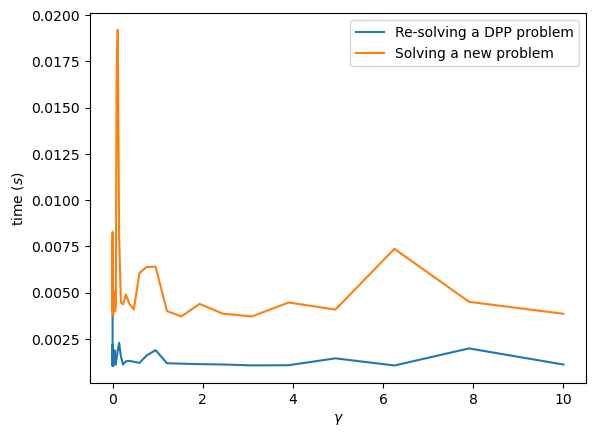

In [49]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

n = 15
m = 10

rng = np.random.default_rng(1)
A = rng.standard_normal((n, m))
b = rng.standard_normal(n)
# gamma must be nonnegative due to DCP rules.
gamma = cp.Parameter(nonneg=True)

x = cp.Variable(m)
error = cp.sum_squares(A @ x - b)

objective = cp.Minimize(error + gamma * cp.norm(x, 1))
prob = cp.Problem(objective)
assert prob.is_dcp(dpp=True)

times = []
new_problem_times = []
gamma_vals = np.logspace(-4, 1)
for val in gamma_vals:
    gamma.value = val
    start = time.time()
    prob.solve()
    end = time.time()
    times.append(end - start)
    new_prob = cp.Problem(objective)
    start = time.time()
    new_prob.solve()
    end = time.time()
    new_problem_times.append(end - start)

_, ax = plt.subplots()
ax.plot(gamma_vals, times, label="Re-solving a DPP problem")
ax.plot(gamma_vals, new_problem_times, label="Solving a new problem")
ax.set_xlabel("$\gamma$")
ax.set_ylabel("time ($s$)")
ax.legend();

### Sensitivity analysis and gradients

An optimization problem can be viewed as a function mapping parameters to solutions. This solution map is sometimes differentiable. CVXPY has built-in support for computing the derivative of the optimal variable values of a problem with respect to small perturbations of the parameters (i.e., the `Parameter` instances appearing in a problem).

The problem class exposes two methods related to computing the derivative. The `derivative` evaluates the derivative given perturbations to the parameters. This lets you calculate how the solution to a problem would change given small changes to the parameters, without re-solving the problem. The `backward` method evaluates the adjoint of the derivative, computing the gradient of the solution with respect to the parameters. This can be useful when combined with automatic differentiation software.

The derivative and backward methods are only meaningful when the problem contains parameters. In order for a problem to be differentiable, it must be DPP-compliant. CVXPY can compute the derivative of any DPP-compliant DCP or DGP problem. At non-differentiable points, CVXPY computes a heuristic quantity.

#### Example.
As a first example, we solve a trivial problem with an analytical solution, to illustrate the usage of the `backward` and `derivative` functions. In the following block of code, we construct a problem with a scalar variable x and a scalar parameter p. The problem is to minimize the quadratic `(x - 2*p)**2`.

In [50]:
import cvxpy as cp

x = cp.Variable()
p = cp.Parameter()
quadratic = cp.square(x - 2 * p)
prob = cp.Problem(cp.Minimize(quadratic))

Next, we solve the problem for the particular value of `p == 3`. Notice that when solving the problem, we supply the keyword argument `requires_grad=True` to the `solve` method.

__NOTE:__ We need to install the following packages.

```
conda install pybind11 threadpoolctl -c conda-forge
pip install diffcp
```

In [51]:
p.value = 3.
prob.solve(requires_grad=True)

2.8398992587956425e-29

Having solved the problem with `requires_grad=True`, we can now use the `backward` and `derivative` to differentiate through the problem. First, we compute the gradient of the solution with respect to its parameter by calling the `backward()` method. As a side-effect, the `backward()` method populates the `gradient` attribute on all parameters with the gradient of the solution with respect to that parameter.

In this case, the problem has the trivial analytical solution `2 * p`, and the gradient is therefore just 2.

In [52]:
prob.backward()
print(f"The gradient is {p.gradient:0.1f}.")

The gradient is 2.0.


Next, we use the `derivative` method to see how a small change in `p` would affect the solution `x`. We will perturb `p` by `1e-5`, by setting `p.delta = 1e-5`, and calling the `derivative` method will populate the `delta` attribute of `x` with the the change in `x` predicted by a first-order approximation (which is `dx/dp * p.delta`).

In this case the solution is trivial and its derivative is just `2 * p`, so we know that the delta in `x` should be `2e-5`.

In [53]:
p.delta = 1e-5
prob.derivative()
print(f"x.delta is {x.delta:2.1g}.")

x.delta is 2e-05.


We emphasize that this example is trivial, because it has a trivial analytical solution, with a trivial derivative. The `backward()` and `forward()` methods are useful because the vast majority of convex optimization problems do not have analytical solutions: in these cases, CVXPY can compute solutions and their derivatives, even though it would be impossible to derive them by hand.

__Note.__ In this simple example, the variable x was a scalar, so the `backward` method computed the gradient of `x` with respect to `p`. When there is more than one scalar variable, by default, `backward` computes the gradient of the sum of the optimal variable values with respect to the parameters.

More generally, the `backward` method can be used to compute the gradient of a scalar-valued function f of the optimal variables, with respect to the parameters. If `x(p)` denotes the optimal value of the variable (which might be a vector or a matrix) for a particular value of the parameter `p` and `f(x(p))` is a scalar, then `backward` can be used to compute the gradient of f with respect to `p`. Let `x* = x(p)`, and say the derivative of `f` with respect to `x*` is `dx`. To compute the derivative of `f` with respect to `p`, before calling `prob.backward()`, just set `x.gradient = dx`.

The `backward` method can be powerful when combined with software for automatic differentiation. We recommend the software package [CVXPY Layers](https://www.github.com/cvxgrp/cvxpylayers), which provides differentiable PyTorch and TensorFlow wrappers for CVXPY problems.

__backward or derivative?__ The `backward` method should be used when you need the gradient of (a scalar-valued function) of the solution, with respect to the parameters. If you only want to do a sensitivity analysis, that is, if all you’re interested in is how the solution would change if one or more parameters were changed, you should use the `derivative` method. When there are multiple variables, it is much more efficient to compute sensitivities using the `derivative` method than it would be to compute the entire Jacobian (which can be done by calling backward multiple times, once for each standard basis vector).